Bert returns:

outputs[0]: logits, 
outputs[1]: hidden_states[optional], 
outputs[2]: attentions[optional

https://www.kdnuggets.com/how-to-visualize-model-internals-and-attention-in-hugging-face-transformers

In [99]:
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

import matplotlib.pyplot as plt
from nltk import bigrams
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [2]:
import torch
torch.cuda.empty_cache() 

In [3]:
def make_n_grams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

def make_n_clause_dict(n):
    """
    Makes sequences of n clauses in the Hebrew Bible, based on a running window.
    """
    n_clause_dict = {}

    for bo in F.otype.s('book'):
        cl_n_grams = list(make_n_grams(L.d(bo, 'clause'), n))
        
        for cl_n_gram in cl_n_grams:
            ch = L.u(cl_n_gram[0], 'chapter')[0]
            book, chapter_number = T.sectionFromNode(ch)
            
            words_n_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_n_gram])))
            heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_n_clause]).strip()
            n_clause_dict[(book, chapter_number, cl_n_gram)] = [book, chapter_number, cl_n_gram, heb_text]

    return n_clause_dict

In [4]:
n_clause_dict = make_n_clause_dict(3)

bib_df = pd.DataFrame(n_clause_dict).T
bib_df.columns = ['book', 'chapter', 'clauses', 'text']
bib_df.head()

book chapter                   clauses  \
Genesis 1 (427559, 427560, 427561)  Genesis       1  (427559, 427560, 427561)   
          (427560, 427561, 427562)  Genesis       1  (427560, 427561, 427562)   
          (427561, 427562, 427563)  Genesis       1  (427561, 427562, 427563)   
          (427562, 427563, 427564)  Genesis       1  (427562, 427563, 427564)   
          (427563, 427564, 427565)  Genesis       1  (427563, 427564, 427565)   

                                                                                 text  
Genesis 1 (427559, 427560, 427561)  בראשׁית ברא אלהים את השׁמים ואת הארץ והארץ הית...  
          (427560, 427561, 427562)  והארץ היתה תהו ובהו וחשׁך על פני תהום ורוח אלה...  
          (427561, 427562, 427563)  וחשׁך על פני תהום ורוח אלהים מרחפת על פני המים...  
          (427562, 427563, 427564)   ורוח אלהים מרחפת על פני המים ויאמר אלהים יהי אור  
          (427563, 427564, 427565)                       ויאמר אלהים יהי אור ויהי אור

In [5]:
bib_ds = Dataset.from_pandas(bib_df)

In [6]:
tokenizer = AutoTokenizer.from_pretrained('dicta-il/BEREL_2.0')

In [7]:
def tokenize(sentence):
  return tokenizer(sentence['text'], max_length=128, truncation=True, padding=True)

tokenized_data = bib_ds.map(tokenize, batched=True) #, remove_columns=raw_data['train'].column_names)
tokenized_data.set_format("pt", columns=["input_ids", "attention_mask"], output_all_columns=True)

tokenized_data = tokenized_data.train_test_split(test_size=0.2)

Map:   0%|          | 0/88053 [00:00<?, ? examples/s]

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = BertForMaskedLM.from_pretrained('dicta-il/BEREL_2.0',
                                        output_hidden_states=True, 
                                        output_attentions=True).to(device)

model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [49]:
def get_model_outputs(model, inputs):
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    #model = model.to(device)
    outputs = model(**inputs)
    return outputs

In [50]:
def split_evenly(l, n):
    len_ = len(l)
    split_size = len_ // n
    split_size = n if not split_size else split_size
    offsets = [i for i in range(0, len_, split_size)]
    return [l[offset:offset + split_size] for offset in offsets]

In [51]:
heb_texts = list(n_clause_dict.values())
heb_texts_n = split_evenly(heb_texts, 1000)

In [52]:
len(heb_texts_n)

1001

In [84]:
new_clauses = """
בראשׁית ברא אלהים את השׁמים ואת הארץ
 דוד מלך
דוד היה מלך
היה דוד מלך

משׁה מלך
משׁה היה מלך
היה משׁה מלך

דוד בירושׁלים
דוד היה בירושׁלים
היה דוד בירושׁלים

דוד ישׁב בירושׁלים
ישׁב דוד בירושׁלים

דוד יושׁב בירושׁלים
יושׁב דוד בירושׁלים
 """

In [85]:
new_clauses = [cl.strip() for cl in new_clauses.split('\n') if cl.strip()]
new_clauses

['בראשׁית ברא אלהים את השׁמים ואת הארץ',
 'דוד מלך',
 'דוד היה מלך',
 'היה דוד מלך',
 'משׁה מלך',
 'משׁה היה מלך',
 'היה משׁה מלך',
 'דוד בירושׁלים',
 'דוד היה בירושׁלים',
 'היה דוד בירושׁלים',
 'דוד ישׁב בירושׁלים',
 'ישׁב דוד בירושׁלים',
 'דוד יושׁב בירושׁלים',
 'יושׁב דוד בירושׁלים']

In [86]:
all_outputs = []

#for text_chunks in all_nom_clauses_n:
    
tokenized_inputs = tokenizer(new_clauses[0], max_length=128, truncation=True, padding=True, return_tensors="pt")
tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
with torch.no_grad():
    outputs = get_model_outputs(model, tokenized_inputs)
    all_outputs.append(outputs)
    #last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
    #hidden_states.append(last_hidden_states)

In [87]:
tokenized_inputs = tokenizer(new_clauses, max_length=128, truncation=True, padding=True, return_tensors="pt")
tokenized_inputs


{'input_ids': tensor([[   1, 3881, 1088, 2280,  337, 2909, 1494, 1312,    2],
        [   1, 1815, 2053,    2,    3,    3,    3,    3,    3],
        [   1, 1815,  435, 2053,    2,    3,    3,    3,    3],
        [   1,  435, 1815, 2053,    2,    3,    3,    3,    3],
        [   1,  998, 2053,    2,    3,    3,    3,    3,    3],
        [   1,  998,  435, 2053,    2,    3,    3,    3,    3],
        [   1,  435,  998, 2053,    2,    3,    3,    3,    3],
        [   1, 1815, 6263,    2,    3,    3,    3,    3,    3],
        [   1, 1815,  435, 6263,    2,    3,    3,    3,    3],
        [   1,  435, 1815, 6263,    2,    3,    3,    3,    3],
        [   1, 1815, 5455, 6263,    2,    3,    3,    3,    3],
        [   1, 5455, 1815, 6263,    2,    3,    3,    3,    3],
        [   1, 1815, 4317, 6263,    2,    3,    3,    3,    3],
        [   1, 4317, 1815, 6263,    2,    3,    3,    3,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

In [88]:
for output in all_outputs:
    print(output.attentions[0].shape)

torch.Size([1, 12, 9, 9])


In [89]:
first_seq_outputs = all_outputs[0]

In [94]:
print(len(first_seq_outputs[0]), len(first_seq_outputs[1]), len(first_seq_outputs[2]))

1 13 12


In [95]:
for att_output in first_seq_outputs[2]:
    print(att_output.shape)

torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])


In [ ]:
# Visualize attention outputs of one layer of one clause

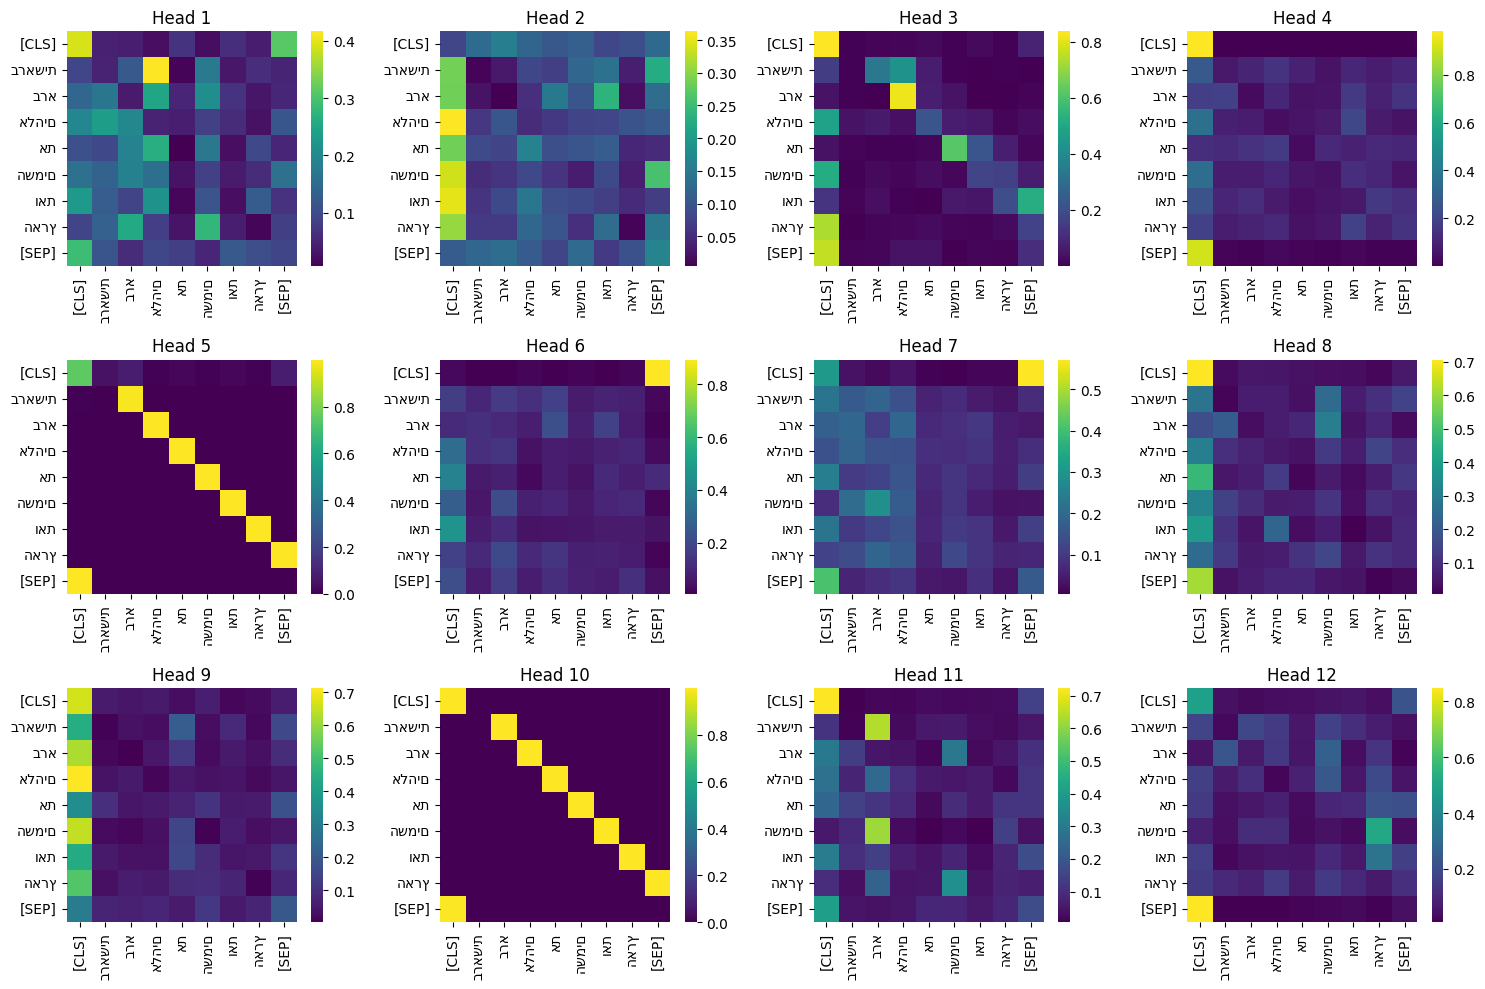

In [121]:
attention = first_seq_outputs[2]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    sns.heatmap(attention[0][0][i].detach().cpu().numpy(), ax=ax, cmap="viridis",
                xticklabels=tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0]),
                yticklabels=tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][0])
               )
    ax.set_title(f"Head {i+1}")
plt.tight_layout()
plt.show()

In [ ]:
# Visualize importance of one token throughout hidden states

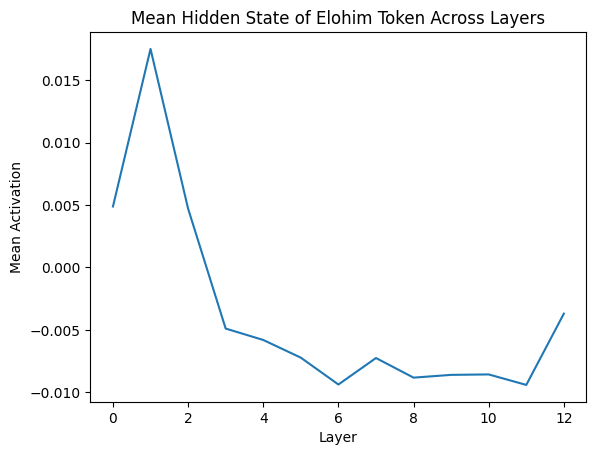

In [129]:
hidden_states = first_seq_outputs[1]

cls_hidden_states = [state[:, 2, :].detach().cpu().numpy() for state in hidden_states]

plt.plot([state.mean() for state in cls_hidden_states])
plt.title("Mean Hidden State of Elohim Token Across Layers")
plt.xlabel("Layer")
plt.ylabel("Mean Activation")
plt.show()